<a href="https://colab.research.google.com/github/doodger/dataScience/blob/master/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Under construction
This project seeks to compare historical American demographic trends and S&P 500 trends

In [0]:
#General Imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error

In [2]:
#Data imports
populationURL = "https://raw.githubusercontent.com/doodger/dataScience/master/38f6e261-94a4-4bdf-b5db-5d75022e46bb_Data.csv"
SaP500URL = "https://raw.githubusercontent.com/doodger/dataScience/master/%5EGSPC.csv"

pop_df = pd.read_csv(populationURL)
sap_df = pd.read_csv(SaP500URL)

##Data cleaning and sorting for the population

#Demographics data
pop_df.head()
#Rows 35,36 and 37 are rows of Nan
#Rows 38 and 39 only have a value at the head, detailling the database's World bank origin

print("Total missing value for rows 0 to 34:",pop_df.loc[0:34].isnull().sum().sum())
pop_df = pop_df.loc[0:34]

#With the un-needed rows cut off, the dataframe can be reordered so that the rows of population groups
#    are in chronological order
pop_df = pop_df.sort_values("Series Code")
#Row 21 is superfluous (65+ women), and can be deleted. The index are then labeled to a proper order
pop_df = pop_df.drop([21])
pop_df.index= [i for i in range(34)]
#The 17 age groups are now in ascending order for both women and men

Total missing value for rows 0 to 34: 0


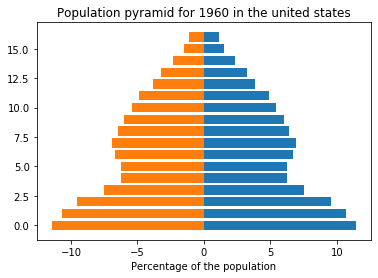

In [3]:
##Visualization

#Sample age pyramid for 1960
yMen = [pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
yWomen = [-pop_df.loc[i,"1960 [YR1960]"] for i in range(1,34,2)]
#Here the women's number will be in the negative by convention


x = [i for i in range(17)]
ax = plt.subplot(111)
ax.barh(x,yMen)
ax.barh(x,yWomen)
plt.xlabel("Percentage of the population")
ax.set_title("Population pyramid for 1960 in the united states")
plt.show()


Total missing value for S&P data: 0


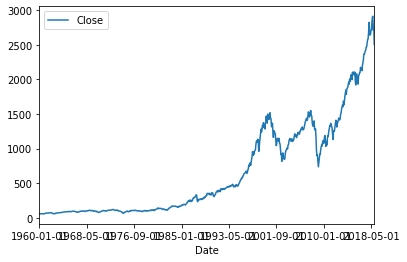

In [5]:
#Financial data
sap_df.head()
print("Total missing value for S&P data:",sap_df.isnull().sum().sum())
#The population data only extends to 2018, and so the 2019 data of the S&P can be cut
#2019 data is from row 708 onward
sap_df = sap_df.loc[0:707]

#History of the S&P500 
sap_df.plot.line(x="Date",y="Close")

## Creating a joint dataset
#Turning the monthly stock market data into annualized data to compare it with the population will be helpful
#To do this a set of yearly statistics for the S&P data will be calculated and afterward both dataframes will be merged into one consolidated dataframe


colAvgClose = [0]*59
colYear = [0]*59
colVolatility = [0]*59
colVolume = [0]*59
colYearlyPercentageVariation = [0]*59
#populating each of the 59 years
for i in range(59):
  colAvgClose[i] = sap_df.loc[i:i+11,"Close"].mean() #yearly mean of closing price
  colVolatility[i] = sap_df.loc[i:i+11,"Close"].std() #experiment to get the volatility in percentage
  colVolume[i] = sap_df.loc[i:i+11,"Close"].mean()

for i in range(1,59):#1960 has no previous year data and thus no percentage variation for now
  colYearlyPercentageVariation[i] = 100*(colAvgClose[i]-colAvgClose[i-1])/colAvgClose[i-1]

#Columns from the S&P set

columns = []
columns.append( ("year", [1960 + i for i in range(59)]) )
columns.append( ("avgClose", colAvgClose) )
columns.append( ("volatility", colVolatility) )
columns.append( ("volume", colVolume) )
columns.append( ("yearPctVar", colYearlyPercentageVariation))
#Columns from the pop set
pop_columns = ["0t4F","0t4M","5t9F","5t9M","10t14F","10t14M","15t19F","15t19M",
               "20t24F","20t24M","25t29F","25t29M","30t34F", "30t34M","35t39F",
                "35t39M","40t44F", "40t44M","45t49F","45t49M",
           "50t54F","50t54M","55t59F","55t59M","60t64F", "60t64M","65t69F","65t69M",
           "70t74F","70t74M",
           "75t79F","75t79M","80pF","80pM"]
for i in range(34):
  columns.append( (pop_columns[i], pd.to_numeric(pop_df.loc[i,"1960 [YR1960]":"2018 [YR2018]"]) ) ) #columns were being copied as object instead of numeric

#creating the joint dataframe
merged_df = pd.DataFrame(dict(columns))
merged_df.index = [i for i in range(59)] #To get rid of inherited index names from pop_df


## Exploratory data analysis
Ideas:

*  Volume?
*  Price increase?
*  Correlation between upward/downward mobility and # of youth/old



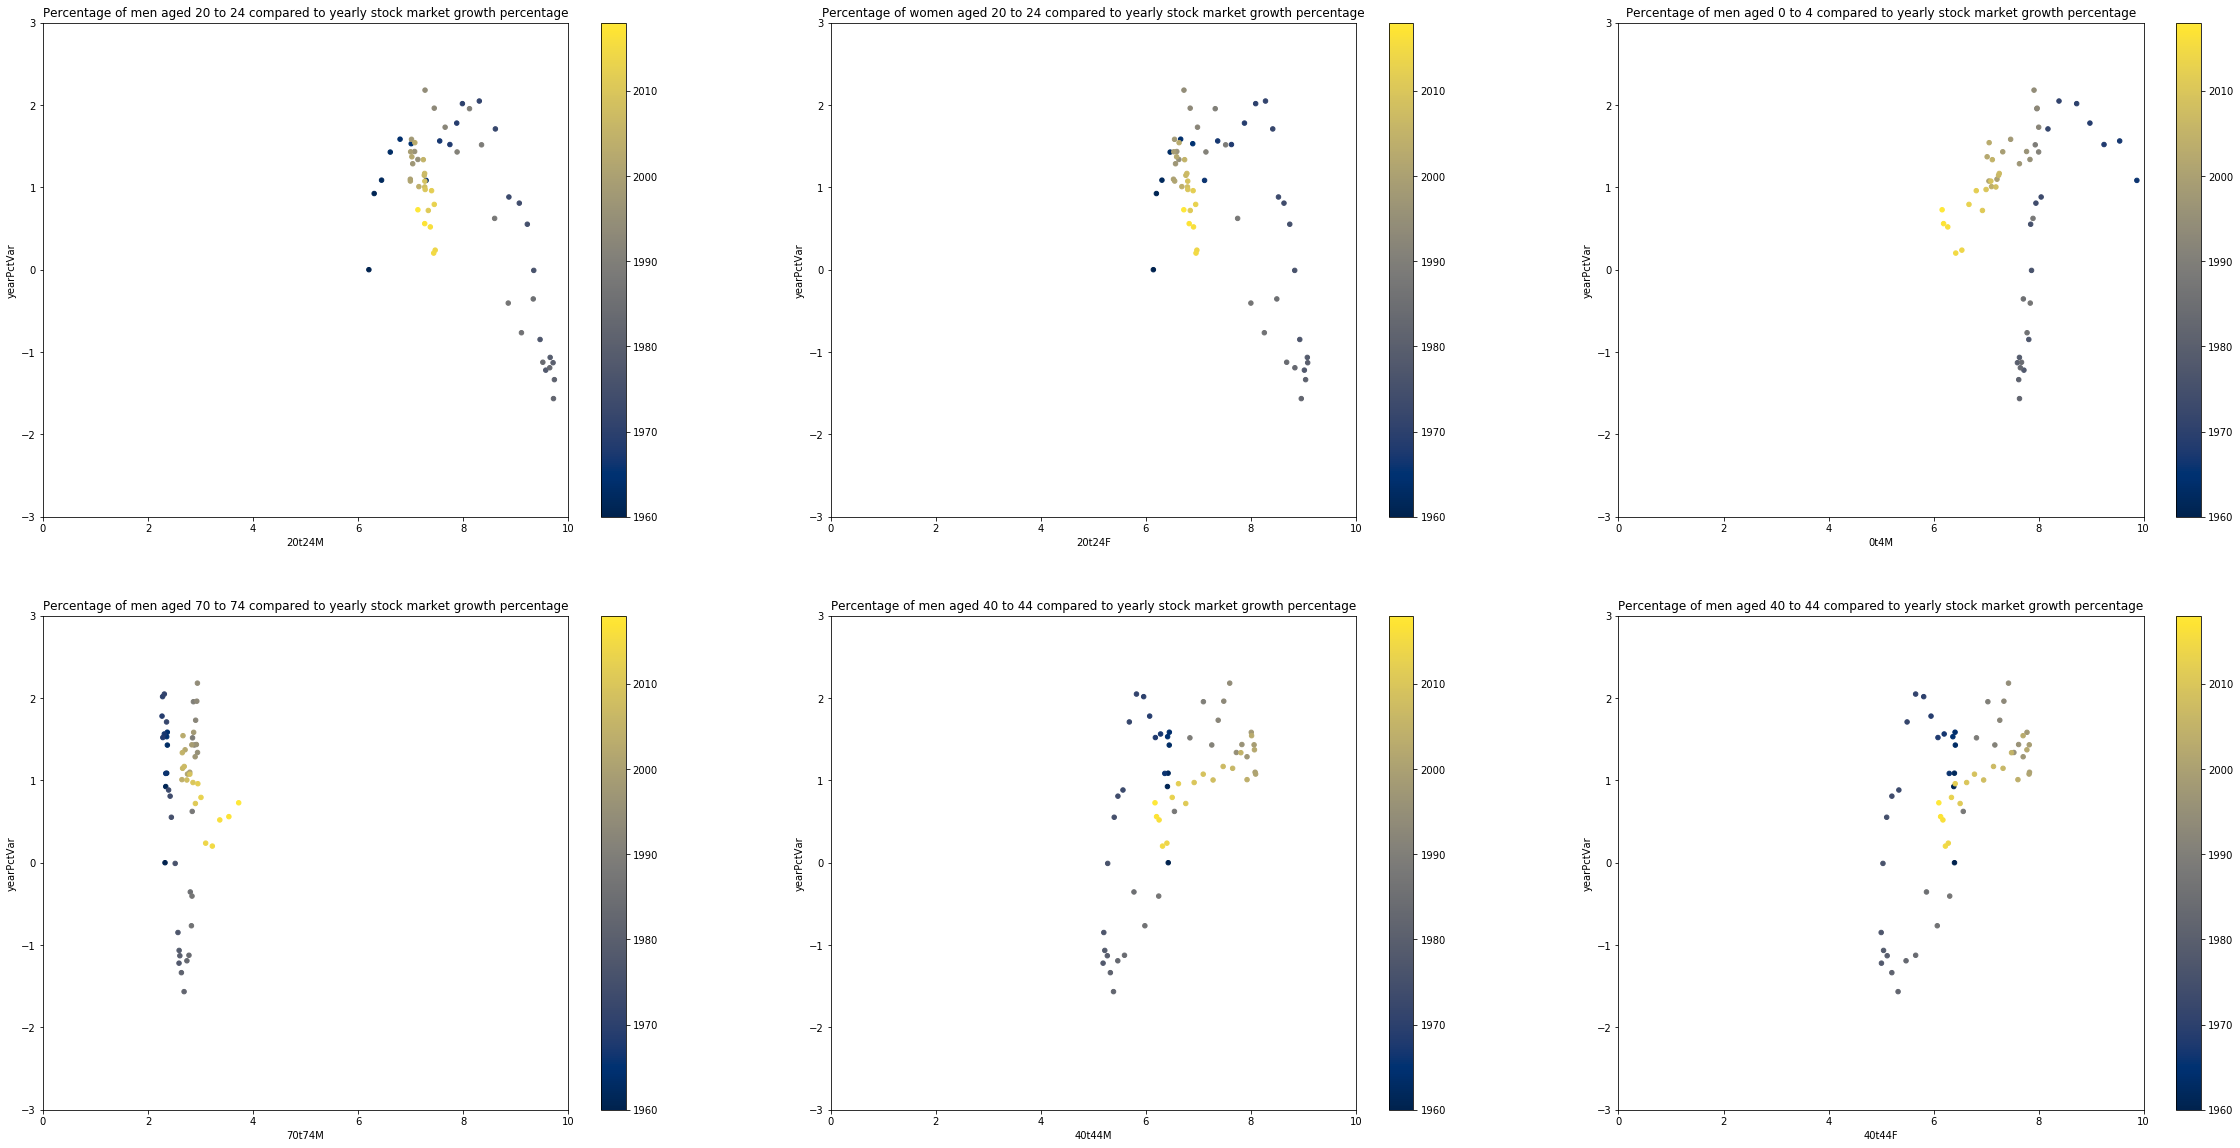

In [6]:
#A few scatter plots of demographic group versus the yearly growth
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(40,20))
plt.setp(axes, xlim=(0,10),ylim=(-3,3))
merged_df.plot.scatter(ax=axes[0,0],x="20t24M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 20 to 24 compared to yearly stock market growth percentage")#young men vs %-variation
merged_df.plot.scatter(ax=axes[0,1],x="20t24F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of women aged 20 to 24 compared to yearly stock market growth percentage")#young women vs %-variation
merged_df.plot.scatter(ax=axes[0,2],x="0t4M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 0 to 4 compared to yearly stock market growth percentage")#male babies vs %-variation
merged_df.plot.scatter(ax=axes[1,0],x="70t74M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 70 to 74 compared to yearly stock market growth percentage")#male retirees vs %-variation
merged_df.plot.scatter(ax=axes[1,1],x="40t44M", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male midlife vs %-variation
merged_df.plot.scatter(ax=axes[1,2],x="40t44F", y="yearPctVar",c=[i for i in range(1960,2019)],cmap="cividis",title = "Percentage of men aged 40 to 44 compared to yearly stock market growth percentage")#male retirees vs %-variation  

In [7]:
corrMatrix = merged_df.corr() #correlation matrix of the merged df
corrMatrix.style.background_gradient(cmap='PiYG', axis=None)

Observation and curious things:



*   Strong correlation of people in their 40s with stock market? Perhaps people are starting to invest for their retirement?
*   Strong negative corellation for people in their 20s with stock market... Perhaps young adults are less likely to invest?
*   Smaller correlation between kids/pre-teens and stock market... Perhaps only tracking that if there's a lot of kids there's probably a lot of adults investing?
*   Financial data is not adjusted to population growth, so it's not surprising that as time goes on and more and more people are alive in the US the volume of trading goes up (among other factors)
*   Volatility of standardized data didn't seem to change much so it was not kept for the time being




Explained % of variance for 2 component PCA: 0.7500213974671512
Explained % of variance for 3 component PCA: 0.9376381886183611


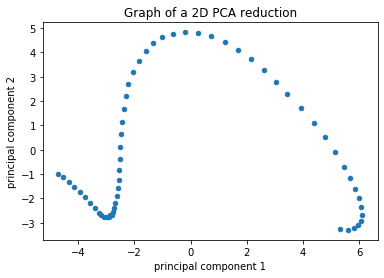

In [8]:
X = merged_df.loc[:,"0t4F":"80pM"] #Don't scale it since the data might not be Gaussian and already same scale?
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalX_df.plot.scatter('principal component 1', 'principal component 2',title="Graph of a 2D PCA reduction")
print("Explained % of variance for 2 component PCA:",sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalX_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalX_df
print("Explained % of variance for 3 component PCA:",sum(pca.explained_variance_ratio_))


Text(1, 2.7, 'MSE:0.36821032480305954')

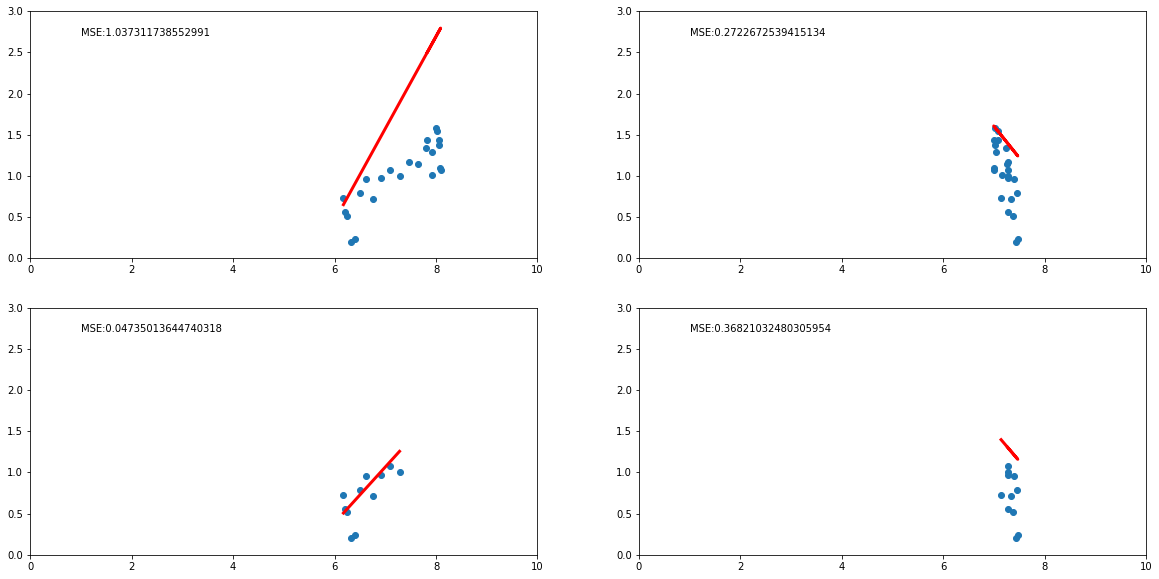

In [90]:
## Model testing


#Just a few linear regressions to begin with?
#A roughly 60-40 split in training and validation is taken
X_train = merged_df.loc[0:35,"0t4F":"80pM"] 
X_test = merged_df.loc[36:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train = merged_df.loc[0:35,"yearPctVar"]
y_test = merged_df.loc[36:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod1 = LinearRegression()
mod1.fit(X_train[["40t44M"]],y_train)
result1 = mod1.predict(X_test[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod2 = LinearRegression()
mod2.fit(X_train[["20t24M"]],y_train)
result2 = mod2.predict(X_test[["20t24M"]])




#A roughly 80-20 split in training and validation is taken
X_train2 = merged_df.loc[0:47,"0t4F":"80pM"] 
X_test2 = merged_df.loc[48:,"0t4F":"80pM"]
#The target will be the yearly percent change in value
y_train2 = merged_df.loc[0:47,"yearPctVar"]
y_test2 = merged_df.loc[48:,"yearPctVar"]

#Simple model where only men of 40 to 44 is used
mod3 = LinearRegression()
mod3.fit(X_train2[["40t44M"]],y_train2)
result3 = mod3.predict(X_test2[["40t44M"]])

#Simple model where men of 20 to 24 is used to predict prices
mod4 = LinearRegression()
mod4.fit(X_train2[["20t24M"]],y_train2)
result4 = mod4.predict(X_test2[["20t24M"]])

#plots
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(20,10))
plt.setp(axes, xlim=(0,10),ylim=(0,3))


axes[0,0].scatter(x=X_test[["40t44M"]], y=y_test)#old men vs %-variation
axes[0,0].plot(X_test[["40t44M"]],result1, color='red', linewidth=3)
axes[0,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result1)))

axes[0,1].scatter(x=X_test[["20t24M"]], y=y_test)#young men vs %-variation
axes[0,1].plot(X_test[["20t24M"]],result2, color='red', linewidth=3)
axes[0,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test,result2)))


axes[1,0].scatter(x=X_test2[["40t44M"]], y=y_test2)#old men vs %-variation
axes[1,0].plot(X_test2[["40t44M"]],result3, color='red', linewidth=3)
axes[1,0].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result3)))


axes[1,1].scatter(x=X_test2[["20t24M"]], y=y_test2)#old men vs %-variation
axes[1,1].plot(X_test2[["20t24M"]],result4, color='red', linewidth=3)
axes[1,1].text(1,2.7,"MSE:"+str(mean_squared_error(y_test2,result4)))


In [0]:
#More model testing, this time a regression with all variables, and then using regularization

#the 80-20 split is retained
X_train = X_train2
X_test = X_test2
y_train = y_train2
y_test = y_test2




In [15]:
merged_df

,year,avgClose,volatility,volume,yearPctVar,0t4F,0t4M,5t9F,5t9M,10t14F,10t14M,15t19F,15t19M,20t24F,20t24M,25t29F,25t29M,30t34F,30t34M,35t39F,35t39M,40t44F,40t44M,45t49F,45t49M,50t54F,50t54M,55t59F,55t59M,60t64F,60t64M,65t69F,65t69M,70t74F,70t74M,75t79F,75t79M,80pF,80pM
0,1960,55.601666,1.382296,55.601666,0.000000,10.774869,11.438166,10.024583,10.641427,8.970117,9.549929,7.180724,7.519980,6.143580,6.206072,5.998961,6.214783,6.585225,6.683991,6.863100,6.921554,6.397916,6.426890,6.050475,6.014327,5.617528,5.439911,5.117633,4.880783,4.260222,3.862331,3.603942,3.213689,2.757785,2.324217,1.991665,1.522627,1.661676,1.139323
1,1961,56.115833,2.256657,56.115833,0.924732,10.702331,11.381676,10.045332,10.672017,9.118514,9.703123,7.434957,7.782729,6.201047,6.306993,5.869454,6.090091,6.365910,6.495126,6.758135,6.819212,6.384526,6.411615,5.992454,5.969349,5.602655,5.420129,5.103825,4.848800,4.283308,3.873290,3.605321,3.168434,2.781829,2.337968,2.001027,1.524913,1.749374,1.194534
2,1962,56.725833,3.092449,56.725833,1.087037,10.506417,11.183908,10.078252,10.721493,9.219836,9.813903,7.718964,8.079322,6.306982,6.447545,5.787910,6.004832,6.148441,6.323720,6.627906,6.693171,6.396803,6.424417,5.939841,5.925501,5.587315,5.418200,5.098101,4.817481,4.323175,3.913119,3.601358,3.117064,2.824388,2.356599,2.005533,1.526442,1.828780,1.233282
3,1963,57.535833,3.871343,57.535833,1.427921,10.219987,10.882823,10.116666,10.778797,9.287382,9.894824,7.999915,8.388771,6.463255,6.613361,5.750699,5.966404,5.944941,6.173400,6.476120,6.549346,6.414075,6.445949,5.903686,5.891580,5.559264,5.419146,5.110025,4.802460,4.366697,3.960600,3.600412,3.076890,2.874921,2.368881,2.017816,1.536358,1.894138,1.250409
4,1964,58.447499,4.320162,58.447499,1.584520,9.899075,10.542620,10.135845,10.813815,9.344493,9.970752,8.243166,8.673193,6.663508,6.799892,5.754819,5.977102,5.770084,6.046372,6.309646,6.399562,6.409003,6.448021,5.889605,5.876202,5.519161,5.413588,5.135565,4.810289,4.404229,3.997550,3.612164,3.062708,2.921573,2.367744,2.046893,1.555910,1.941172,1.244682
5,1965,59.341666,4.811621,59.341666,1.529862,9.584512,10.213357,10.102421,10.787300,9.409482,10.060468,8.435539,8.909088,6.893363,7.011716,5.802015,6.029693,5.633276,5.945835,6.135857,6.254859,6.367385,6.414836,5.894766,5.881215,5.479013,5.403243,5.159778,4.833735,4.439043,4.024156,3.639238,3.075579,2.959758,2.356700,2.092881,1.578718,1.971675,1.219501
6,1966,59.984999,4.971830,59.984999,1.084118,9.235697,9.870731,10.026761,10.727475,9.493930,10.166323,8.606560,9.019816,7.118414,7.296071,5.899564,6.124115,5.541492,5.852379,5.966506,6.125155,6.298169,6.361122,5.910929,5.905966,5.460282,5.385377,5.126468,4.810925,4.491791,4.053910,3.667634,3.087425,2.963587,2.337970,2.125432,1.589437,2.066783,1.285804
7,1967,60.922499,5.110045,60.922499,1.562891,8.910760,9.543363,9.897738,10.616675,9.572914,10.276699,8.733934,9.115505,7.368436,7.554658,6.026629,6.268241,5.490240,5.793522,5.791671,5.991005,6.201779,6.280875,5.941398,5.951549,5.450531,5.374872,5.087674,4.794378,4.535216,4.072620,3.719534,3.125630,2.963375,2.310833,2.162179,1.594737,2.145993,1.334837
8,1968,61.848333,5.328632,61.848333,1.519690,8.617060,9.245412,9.718796,10.456994,9.636842,10.365175,8.827671,9.241152,7.630323,7.748617,6.176801,6.458134,5.481180,5.779095,5.622723,5.854647,6.083343,6.181636,5.973670,6.001188,5.445498,5.373627,5.058681,4.790842,4.558811,4.076420,3.790641,3.185069,2.967492,2.282456,2.199704,1.597306,2.210763,1.362229
9,1969,62.949166,4.788861,62.949166,1.779892,8.350535,8.976671,9.506571,10.262220,9.666254,10.413333,8.910377,9.407935,7.878322,7.878748,6.349697,6.672023,5.511016,5.814730,5.477115,5.728504,5.951253,6.073032,5.987282,6.032163,5.448067,5.388479,5.047302,4.800958,4.562761,4.072221,3.868047,3.249814,2.988155,2.267482,2.234030,1.595879,2.263215,1.365808


TODO


*   better age pyramid (inverse y axis, positive label instead of negative for women)
*   Monthly volatility into yearly volatility?
*   Price needs to be in % variation I think
*   Should first column of percentage variation be 0 or N/A? look up from previous year?
*   give yearpctvar a proper name without breaking heatmap?
*   Women poorer?
*   Non linear stuff?
*   Scatter plot with color for year + labels + same scale
*   PCA of only population data?
*   K-Cross validation on 10-25 period of years?
*   Volatility adjusted to volume?



Links on the topic
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89